In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import datetime
import time
%matplotlib inline

### Loading data

In [2]:
raw_train=pd.read_csv('exercise_06_train.csv')
raw_test=pd.read_csv('exercise_06_test.csv')

In [3]:
raw_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,...,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-18.801830,thur,-6.552566,9.538784,1.312835,-30.919756,-1.746701,10.353219,7.540528,2.367213,3.348712,-54.069890,$567.15,0.065575,-11.779050,22.508336,-13.597729,-14.842697,-5.871685,5.247740,-2.998574,-1.422840,2.338404,-2.555334,-19.045333,-74.653018,60.002022,-13.487795,1.905829,-1.845035,-18.003453,-0.335476,4.359108,-11.038446,3.417906,3.911575,6.626979,157.343439,-2.545061,0.101564,...,42.226035,69.412056,-0.472639,-0.194821,38.176401,-1.792892,1.886821,-4.182808,-1.672980,-0.255597,11.943283,-2.397448,12.635588,2.249390,-0.315405,0.091295,-8.269191,1.882057,0.01%,-39.230676,9.004164,asia,0.920774,Toyota,-0.417567,-2.178081,1.520310,8.832329,2.541372,2.346655,1.123002,0.100649,-2.289470,-31.647151,33.027017,0.185422,6.273963,13.979704,-6.463642,1
1,-10.067812,thur,0.729611,20.360833,-3.613123,-17.570984,2.543479,-15.372645,115.017876,6.575745,-3.398485,15.106741,($222.52),0.198136,13.770658,-17.315784,-40.915477,-11.088756,42.595312,1.018709,-4.443998,-0.319071,-4.978504,0.297055,3.464624,22.306253,-8.579242,3.111269,0.254414,0.032234,-12.927077,-1.825500,-1.703113,-17.020095,-4.402624,-6.965128,-3.432819,17.767578,-4.574300,-0.202409,...,-18.935585,37.269151,-10.785783,-0.819124,-16.884761,-0.601948,-3.579686,-11.361753,-22.052545,-0.060350,11.133021,-1.192583,-27.825058,0.680800,-5.132030,-0.048819,3.257155,-12.153549,-0.01%,-6.874520,-34.945523,asia,0.166055,bmw,-0.399983,0.732224,-5.133449,12.290699,-21.463090,3.118563,2.164270,0.115138,-10.523961,-43.017759,-13.975430,-1.361422,0.013210,-29.676227,-0.632905,0
2,32.090898,wed,0.337504,0.656304,1.486507,-41.844111,-6.575336,-35.273596,69.702872,6.776646,-2.902368,61.800923,$55.12,0.152788,-7.173478,-66.131468,-4.685525,-4.262447,-4.173604,-2.733335,4.944270,-1.208553,-1.307908,5.695403,-3.359242,-0.883903,-29.747042,42.852595,-2.261591,-9.182369,-7.240073,1.425148,7.714303,-25.310673,-1.642204,-7.046861,12.425282,50.158000,0.396313,0.889537,...,-1.159049,-11.444183,4.091415,0.004673,-33.080238,1.277872,19.476544,13.516130,61.725362,0.064698,6.532964,-0.368351,70.361863,-4.819289,25.641672,-0.065262,-10.976856,-9.806330,0.00%,57.115079,-24.382509,asia,-1.216999,volkswagon,-0.697741,-1.033883,-7.411270,10.894618,-11.554596,-2.677601,4.791612,0.188479,-13.207637,-36.059895,-10.711337,8.228320,0.944817,-1.313898,-4.071025,0
3,8.032520,thurday,-1.066729,-26.137688,1.239016,10.016360,0.750321,-0.189688,54.489425,7.047990,3.858303,-25.349009,($698.53),0.086444,11.013212,-124.871546,-34.149883,-16.442205,18.195837,-4.616718,4.707804,0.234799,1.983293,-1.315793,10.268216,-11.934356,0.113968,9.813742,-0.789969,-5.404434,13.940158,0.297427,25.274291,11.163432,-3.735563,6.454297,5.431348,170.722714,-2.401625,2.133073,...,5.758875,8.141856,0.707136,-0.176922,-77.021713,-1.515892,-4.319816,3.696878,51.924923,0.229862,-0.361334,-1.618467,4.192939,5.173838,-4.965997,0.141721,4.462892,8.850728,-0.01%,-8.225656,-2.370924,euorpe,-0.823679,Toyota,-0.377556,0.864032,8.384014,-0.241435,31.002502,-0.616081,-6.865662,-0.237309,-18.353940,-33.980075,49.143130,3.353182,-4.094337,11.922088,-2.627234,0
4,-29.852847,thurday,5.551189,6.719916,-0.844864,24.908333,-3.633462,-10.470385,-46.300708,-11.035877,7.657838,107.444943,($486.68),-0.017869,10.472871,21.574226,-27.974980,5.421133,-15.627260,6.002538,-3.705134,-1.090999,-1.903119,11.260669,-31.584196,33.068379,-19.237344,-16.373520,-3.180830,-2.255761,-0.644797,0.462583,-9.577486,-15.229717,-11.315395,-15.542363,-3.811437,-71.682949,5.853456,0.362370,...,-1.233756,38.779460,-29.026367,-0.476915,-23.180506,-0.709178,-3.671709,-6.692844,9.008700,0.367427,-23.276018,-2.085619,0.882846,5.626529,5.577888,0.113531,19.000833,0.929884,-0.01%,36

In [4]:
print(raw_train.shape)

(40000, 101)


In [5]:
### Drop NULL values in column x1
raw_train_drop = raw_train.dropna(axis=0,subset=['y'])

In [6]:
print(raw_train_drop.shape)

(40000, 101)


In [7]:
### Combine train and test data
list_all=[raw_train_drop,raw_test]
raw = pd.concat(list_all,ignore_index=True)

In [8]:
len_train = len(raw_train_drop)
len_test =len(raw_test)
print('The size of effective training and test dataset is', len_train, len_test)

The size of effective training and test dataset is 40000 10000


In [9]:
del(raw_train,raw_test,raw_train_drop)

In [10]:
### Get percentage of NULL values for each feature
Null_list = raw.isnull().sum().sort_values(ascending=False)/float(raw.shape[0])*100
print('the pencentage of NUll value in each features are:', Null_list[:10])

the pencentage of NUll value in each features are: y      20.000
x13     0.034
x55     0.034
x42     0.034
x18     0.032
x62     0.030
x99     0.030
x24     0.030
x96     0.028
x63     0.028
dtype: float64


### Feature Selection

In [11]:
#remove features not used for modeling
del raw['x2']
del raw['x3']
del raw['x19']

#These feature need Nature Language Processing before using, thus increasing the complexity of current model
del raw['x10']
del raw['x16']
del raw['x18']

#Remove redundant feature
del raw['x8']

### Feature Engineering

In [12]:
# Remove $ from dollar amount features
def remove_dollar(x):
    try:
        x = str(x)
        return float(x.strip('$').replace(',',''))
    except:
        return np.nan

In [13]:
raw['x4'] = raw['x4'].apply(remove_dollar)
raw['x5'] = raw['x5'].apply(remove_dollar)
raw['x6'] = raw['x6'].apply(remove_dollar)
raw['x12'] = raw['x12'].apply(remove_dollar)

In [14]:
# Convert the variable format from percentage to float
def per_float(x):
    try:
        x = str(x)
        return float(x.strip('%'))/100
    except:
        return np.nan

In [15]:
raw['x30'] = raw['x30'].apply(per_float)

In [16]:
# Create new features to be used in modeling
raw['x33'] = raw['x5']/raw['x4']
raw['x34'] = raw['x6']/raw['x5']

In [17]:
# Convert time from string format to float (Number of years since 1900-01-01)
def toYears(x):
    try:
        x = datetime.datetime.strptime(x, "%b-%Y")
        x = x-datetime.datetime(1900,1,1)
        return x.days/365.0
    except:
        try:
            x = datetime.datetime.strptime(x, "%b-%y")
            if (x - datetime.datetime(2017,12,31)).days> 0:
                x = x-datetime.datetime(2000,1,2)
                return x.days/365.0
            x = x-datetime.datetime(1900,1,1)
            return x.days/365.0        
        except:
            return np.nan

In [18]:
raw['x15'] = raw['x15'].apply(toYears)
raw['x23'] = raw['x23'].apply(toYears)

In [19]:
# Time difference between issue date and the date opened
raw['x35'] = raw['x15']  - raw['x23']

In [20]:
### Set target variable and remove it from input variable list
raw_y = raw['y']
del raw['y']

### Split input variables into numerical features and categorical features

In [21]:
cat_cols = raw.dtypes[raw.dtypes == 'object'].index
num_cols = raw.dtypes[raw.dtypes == 'float64'].index

### Make statistics analysis on target variables, numerical features and categorical features
### This cell is very slow to run analysis. Don't run unless you're interested in viewing individual features'

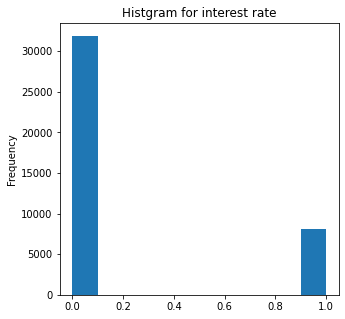

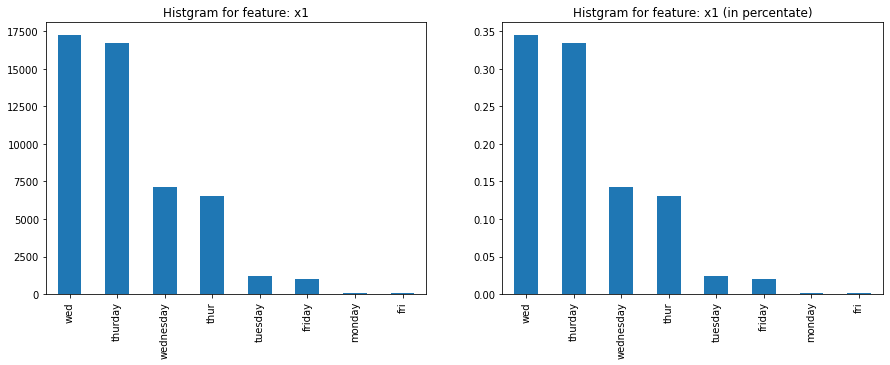

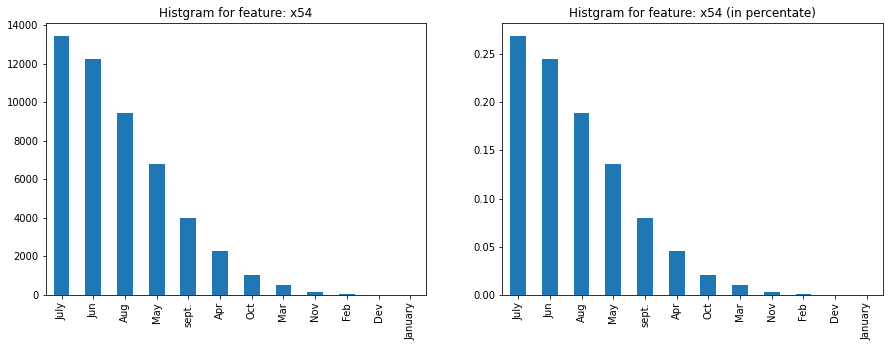

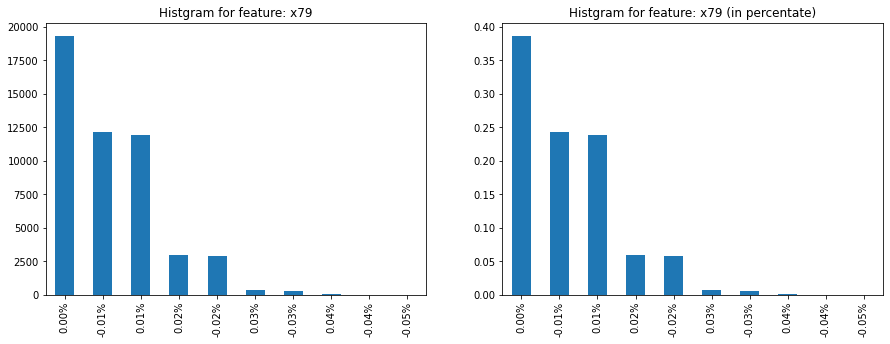

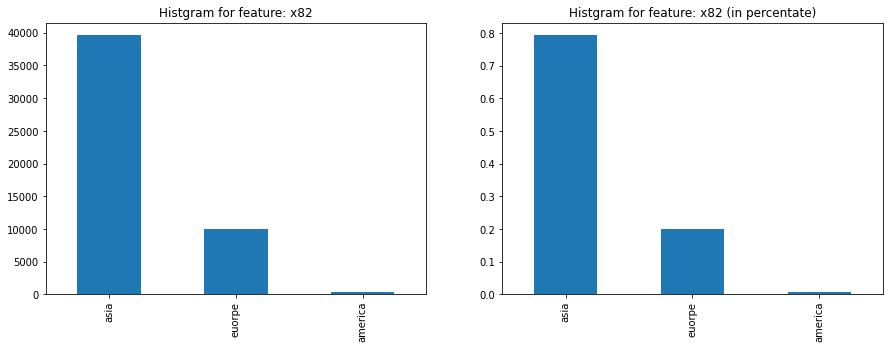

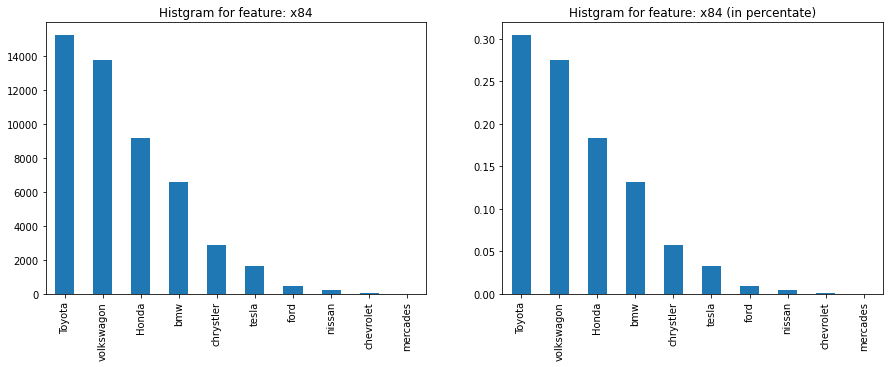

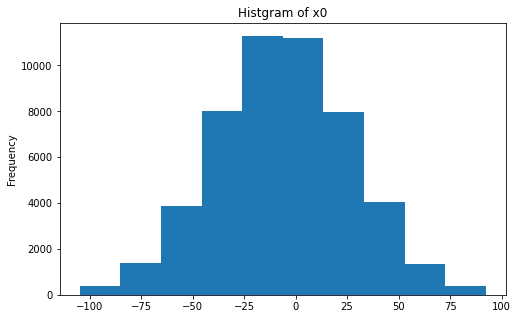

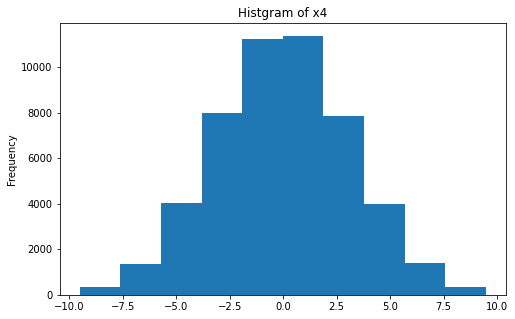

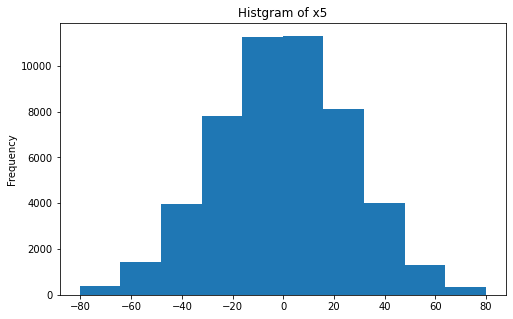

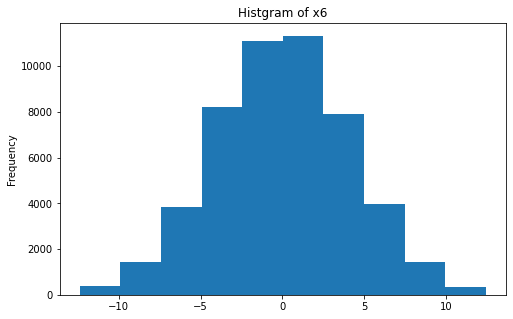

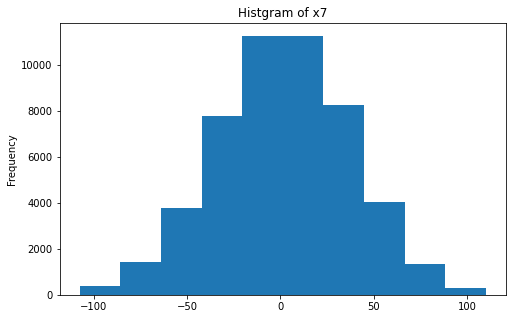

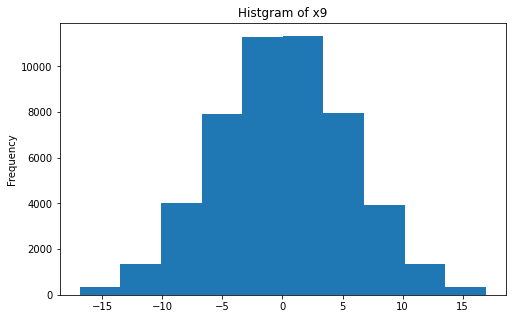

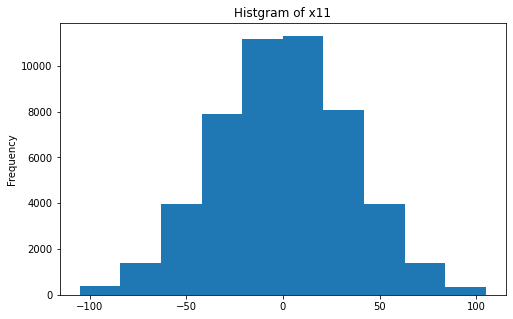

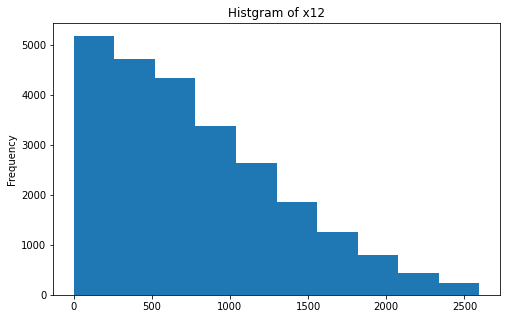

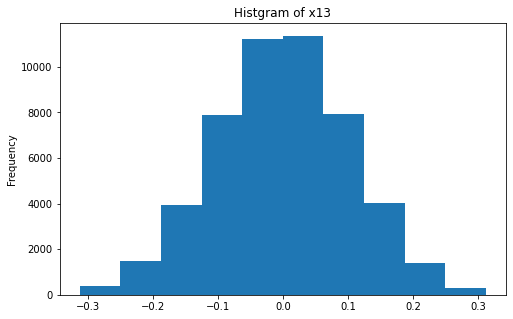

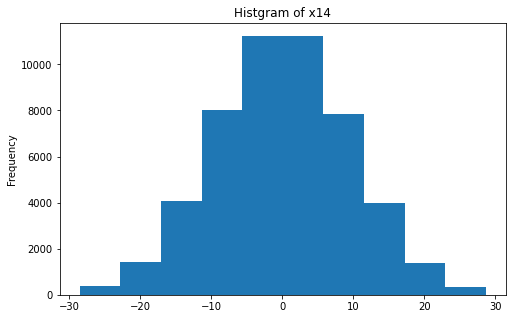

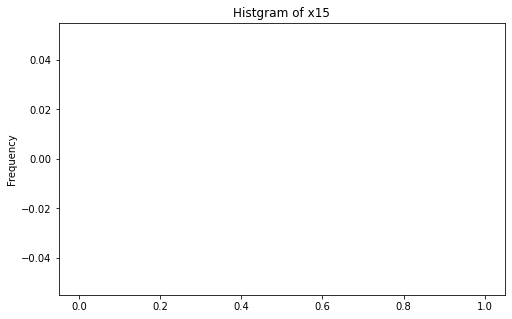

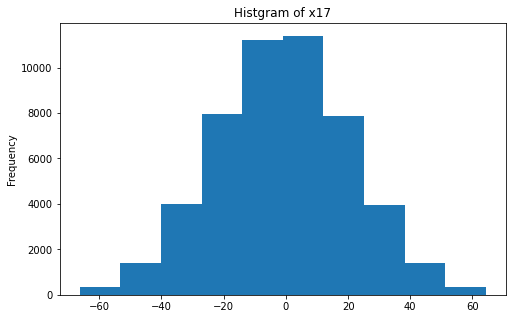

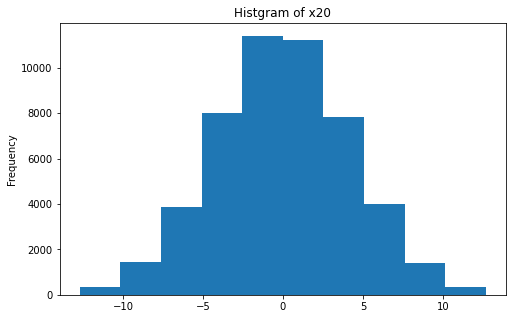

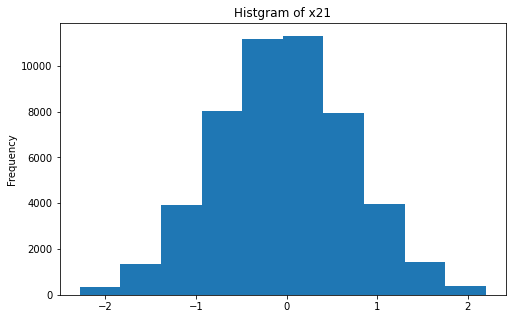

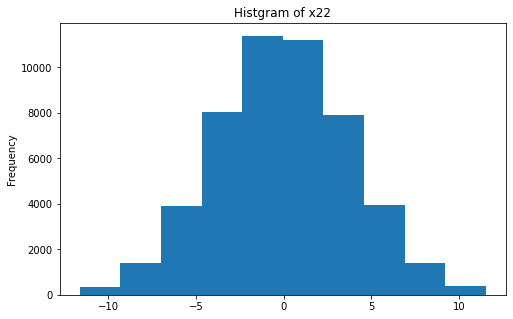

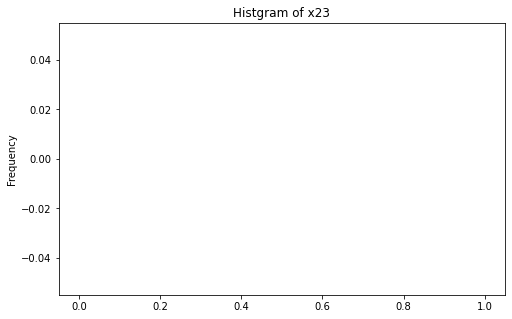

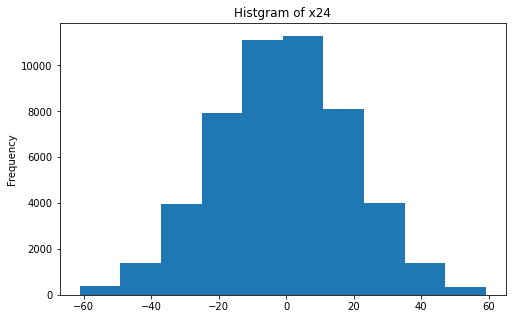

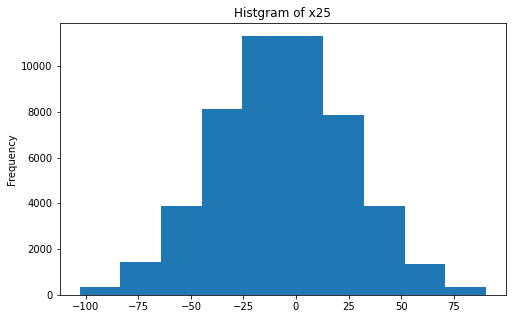

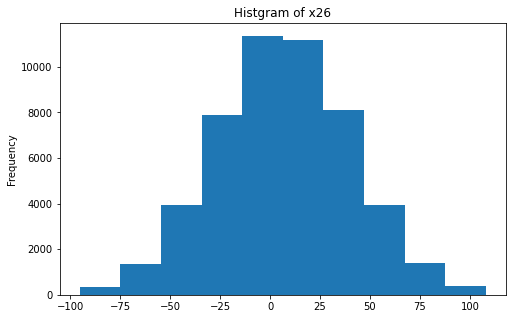

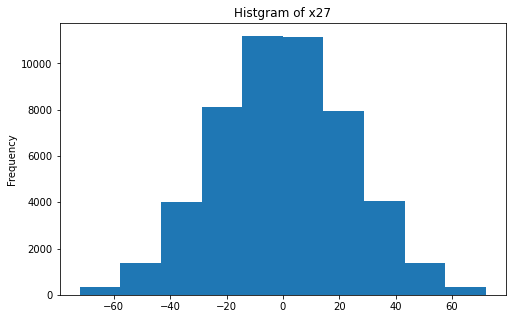

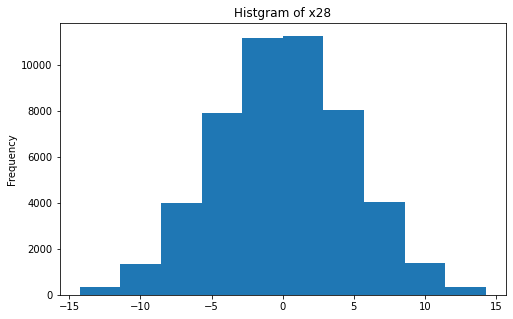

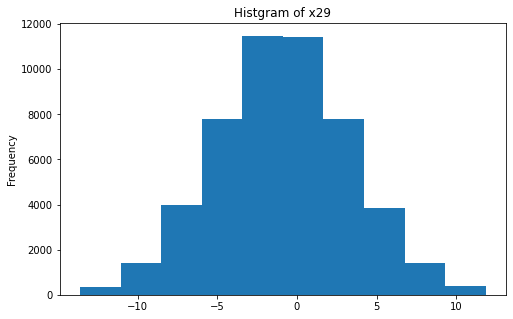

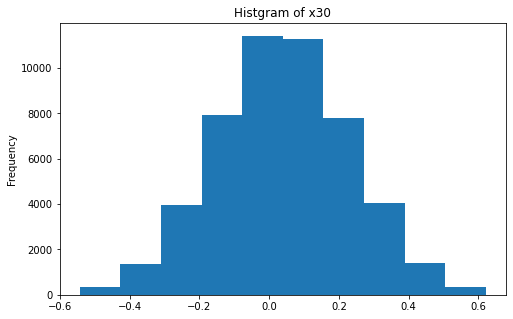

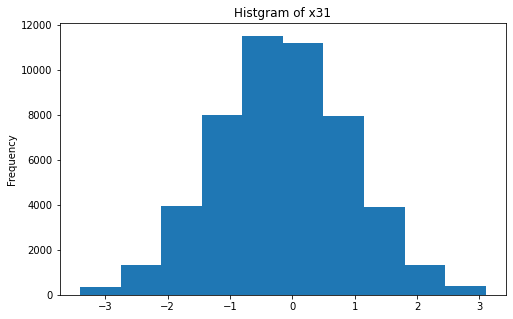

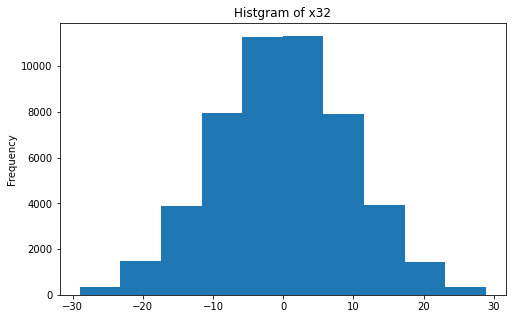

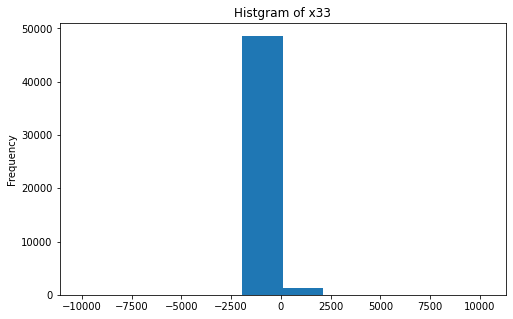

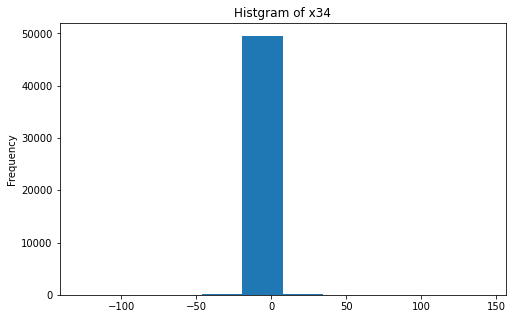

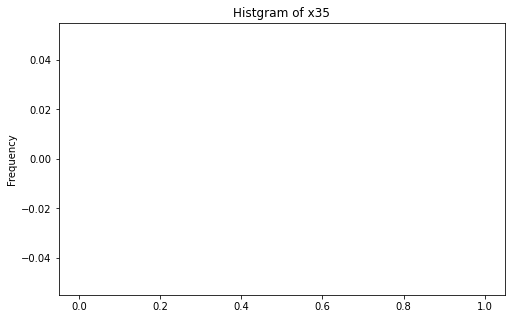

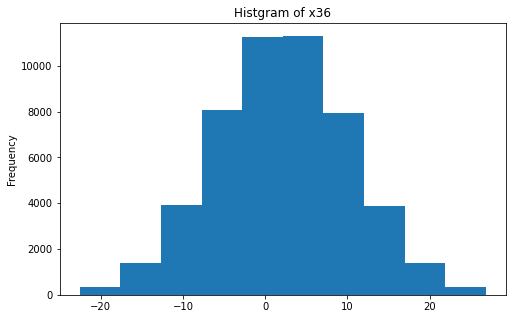

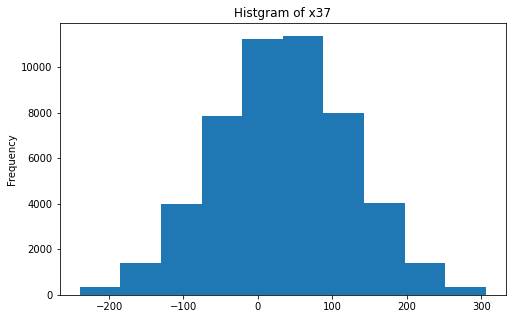

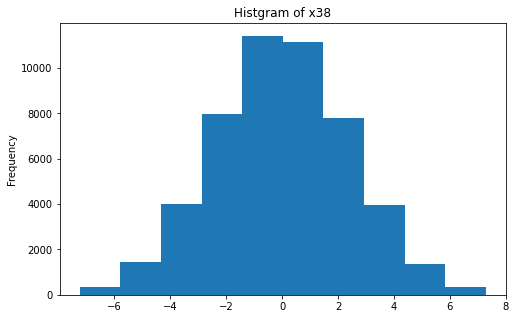

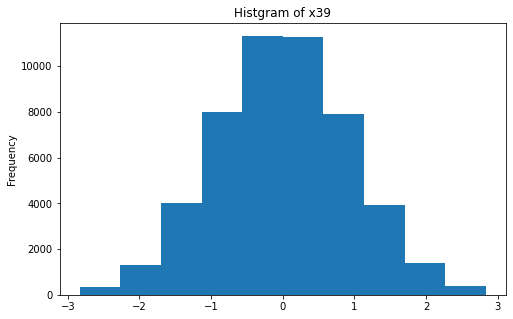

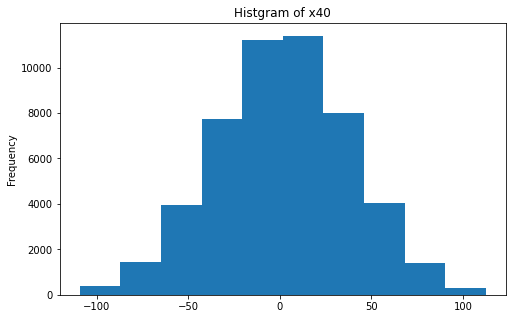

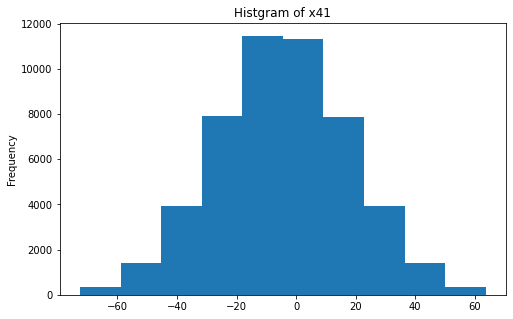

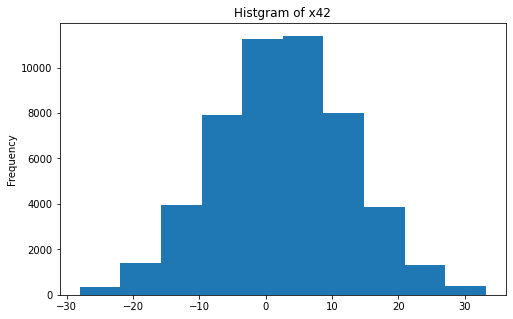

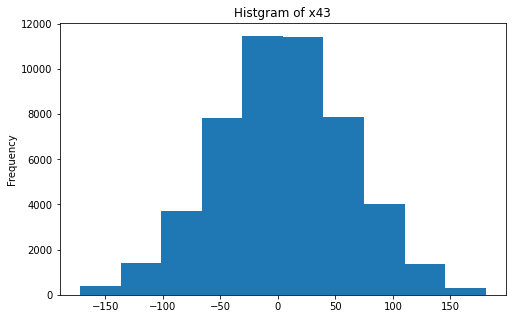

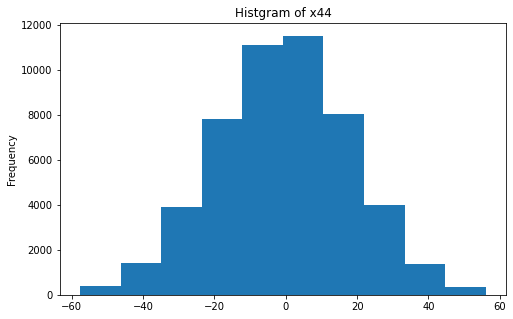

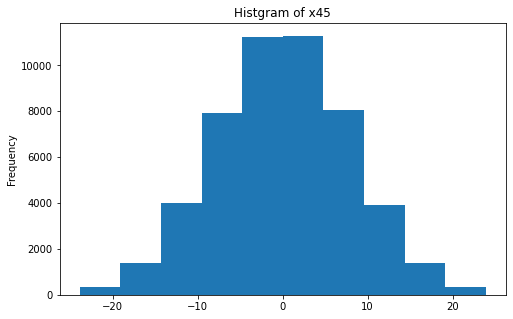

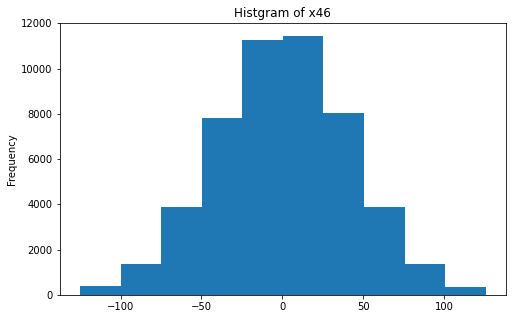

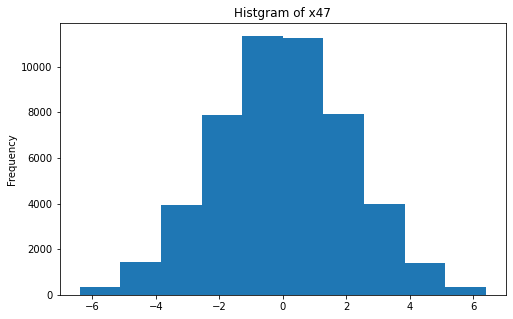

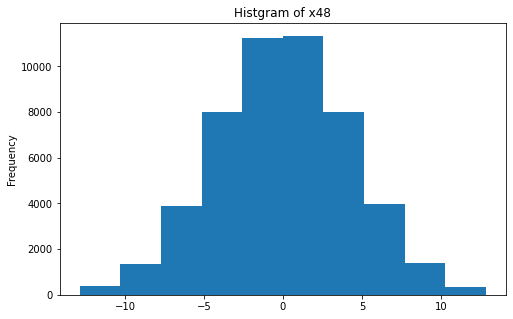

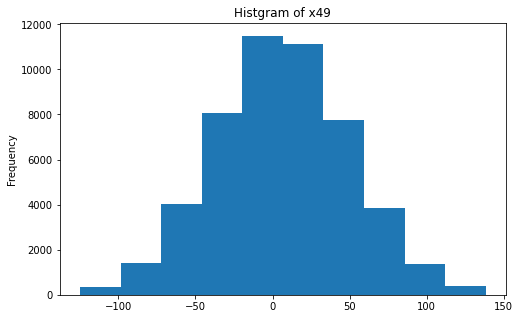

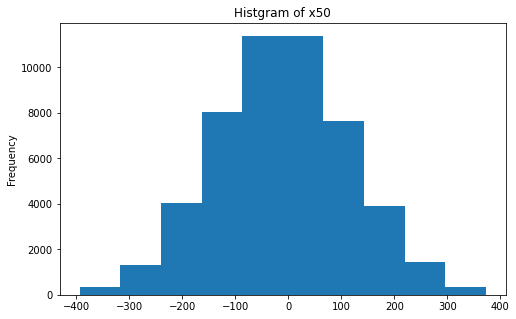

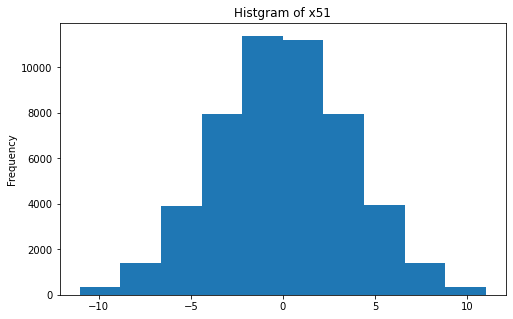

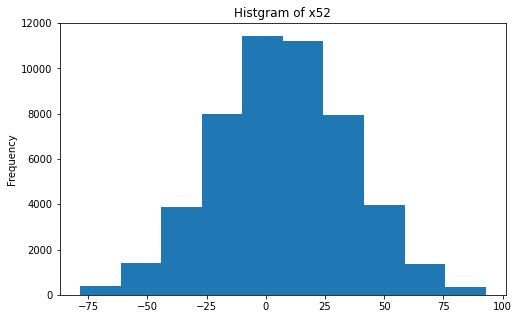

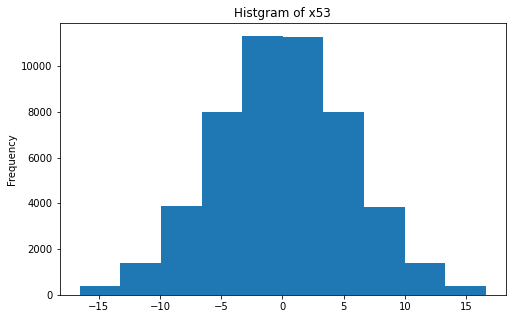

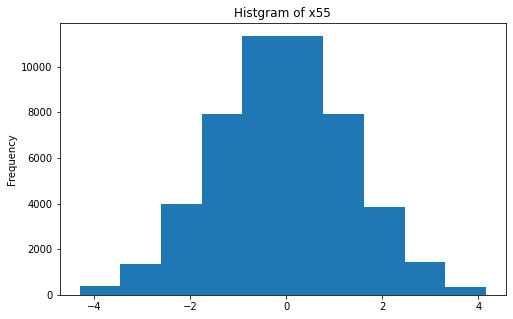

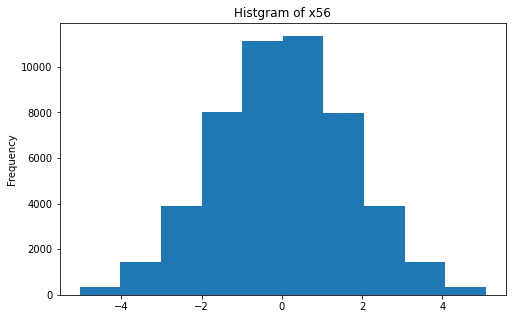

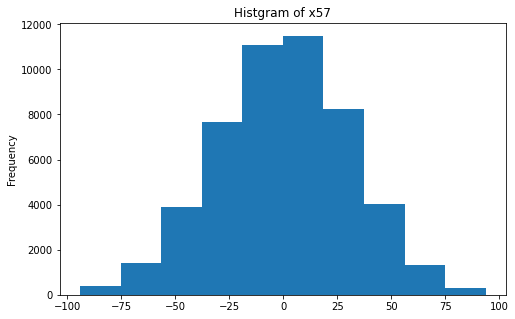

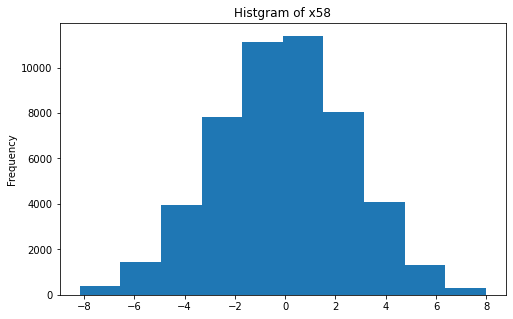

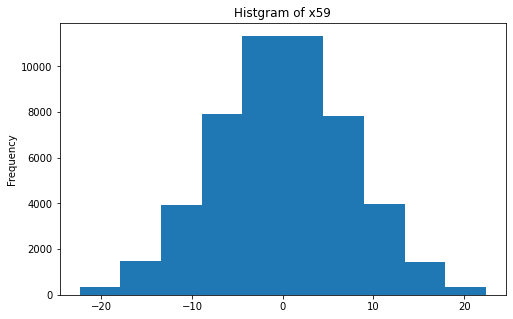

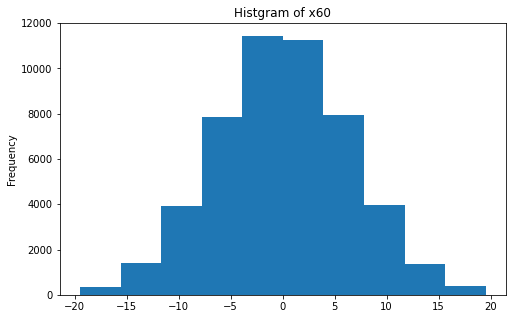

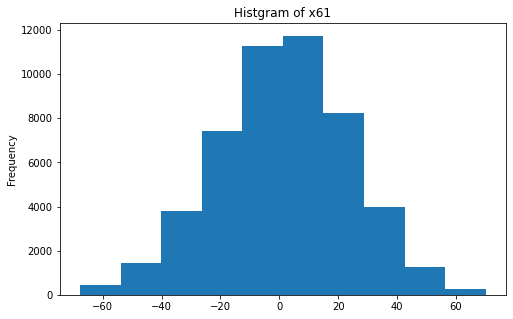

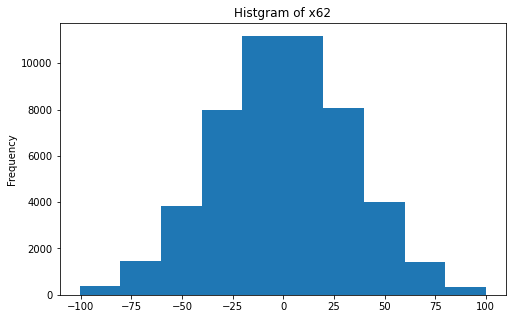

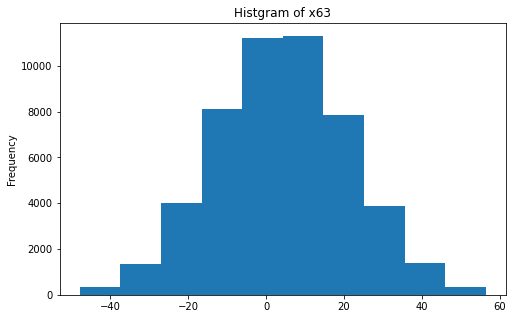

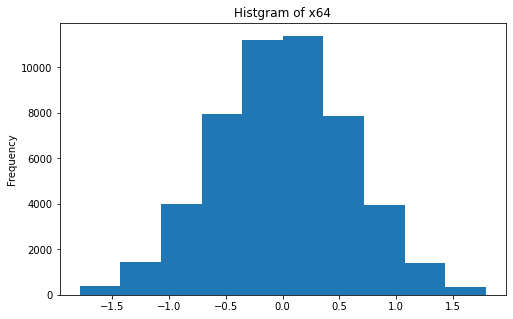

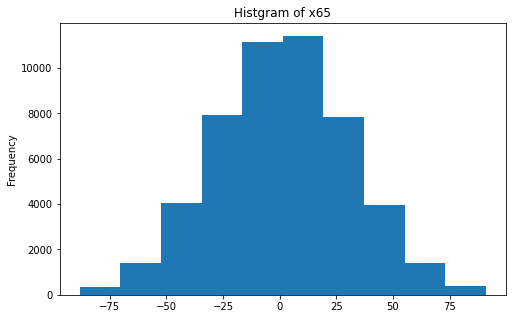

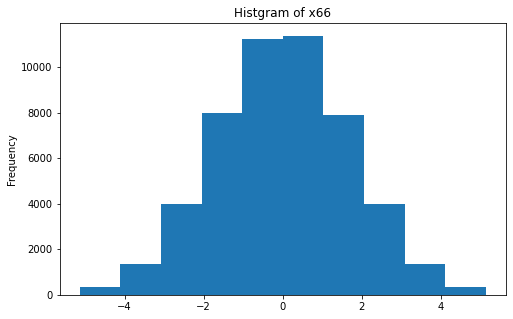

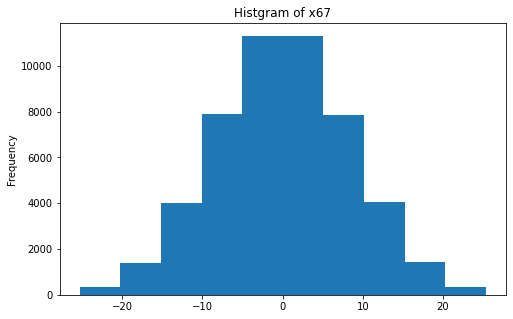

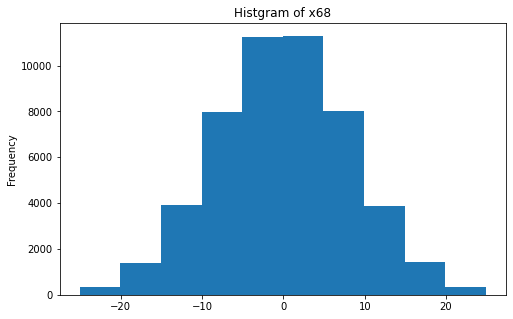

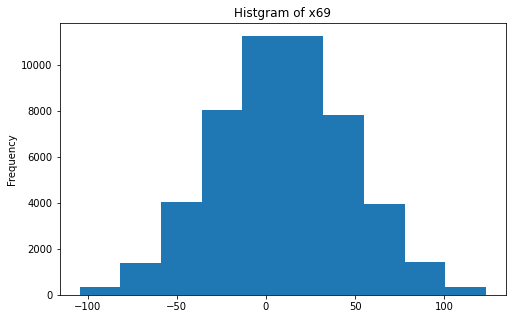

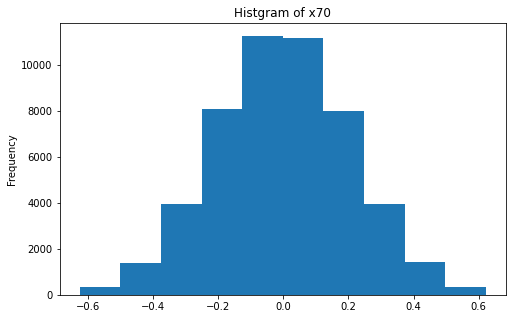

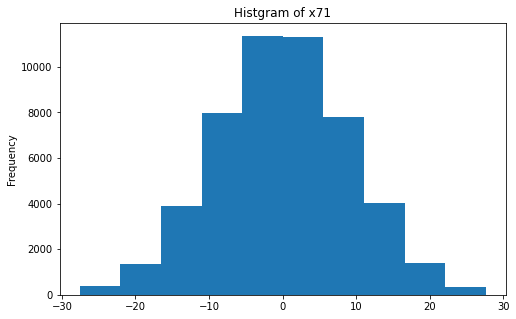

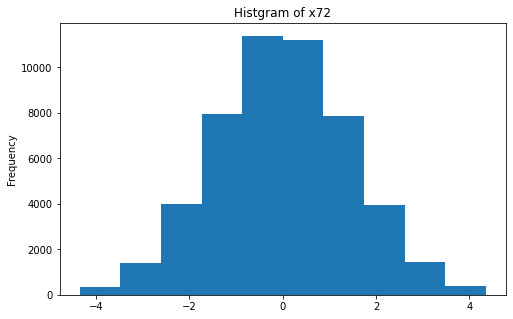

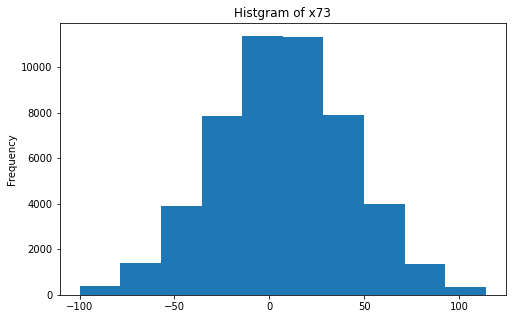

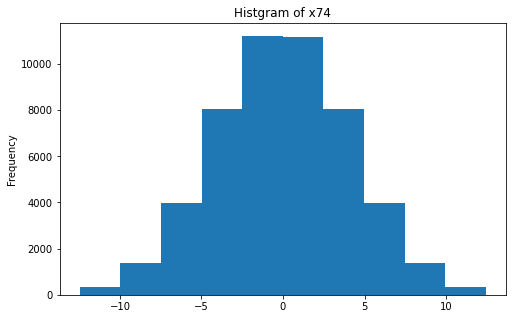

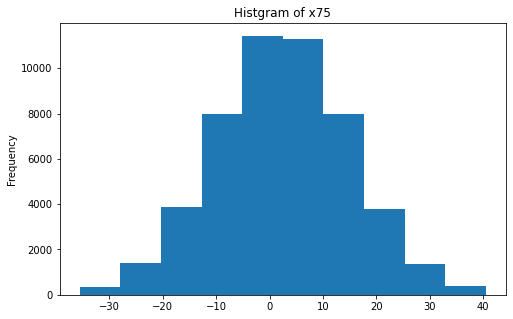

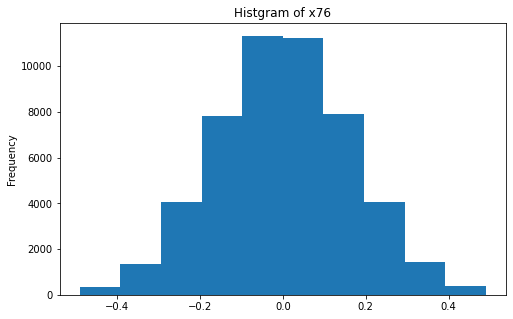

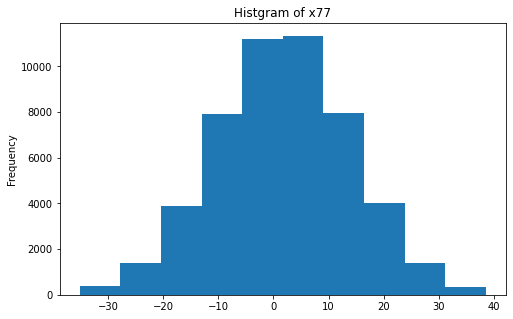

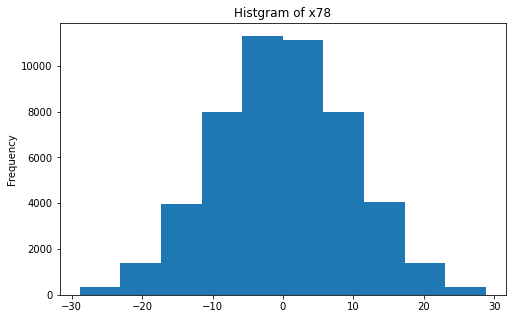

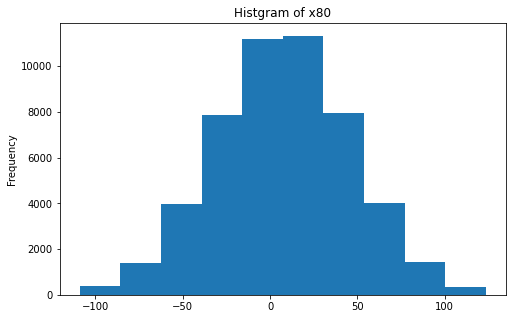

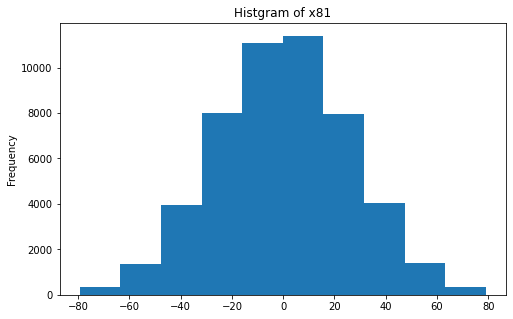

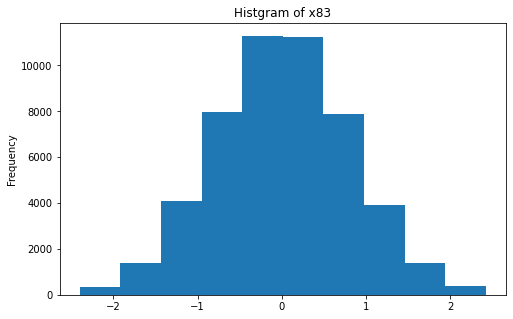

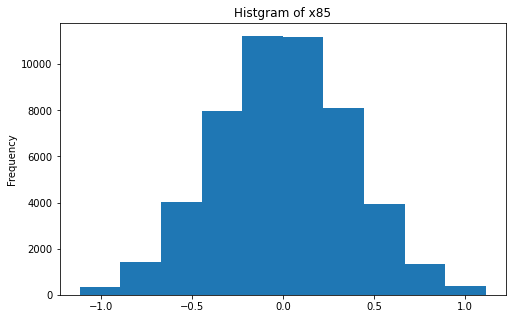

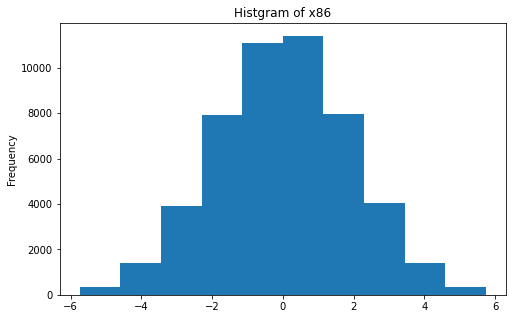

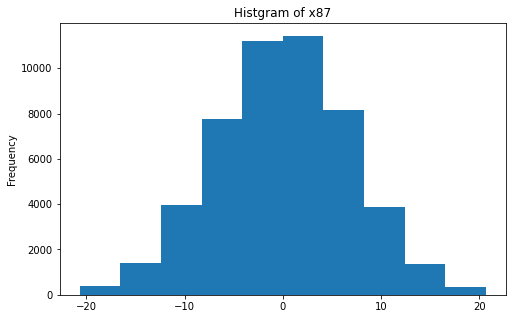

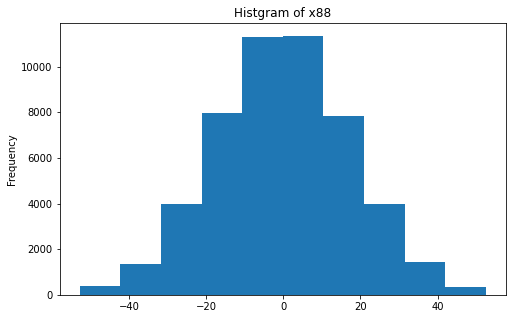

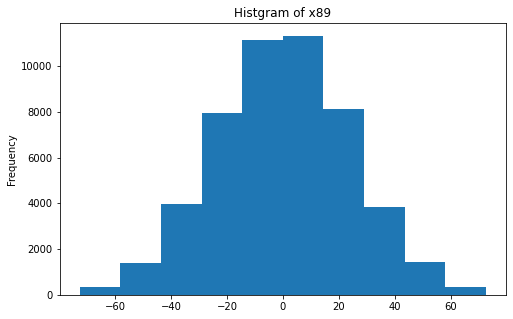

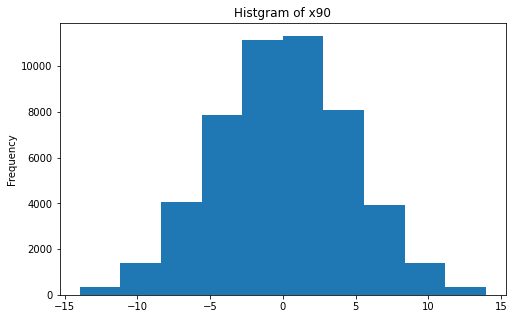

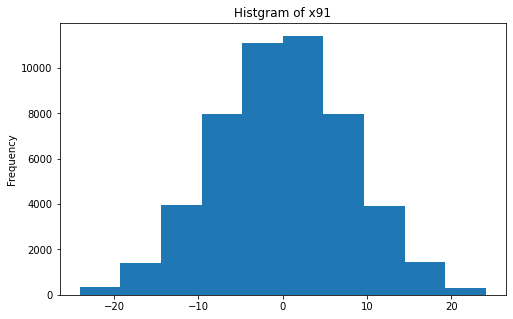

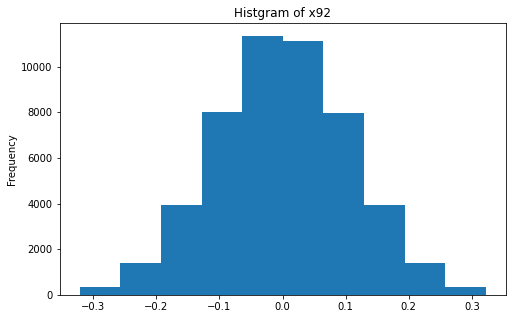

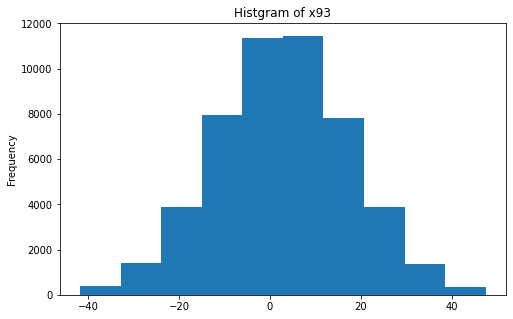

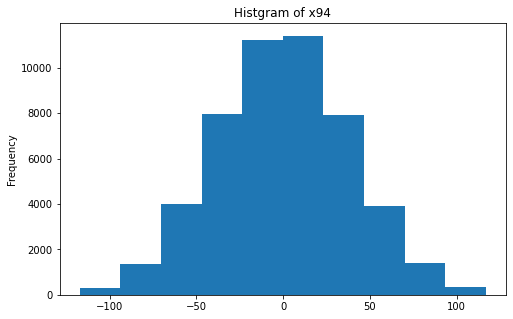

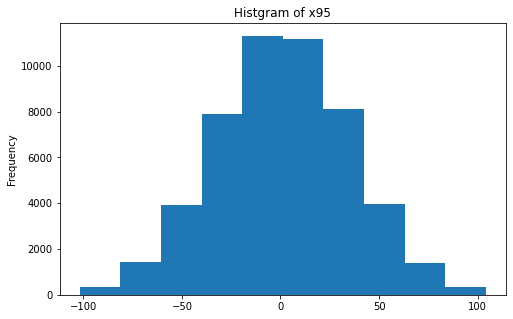

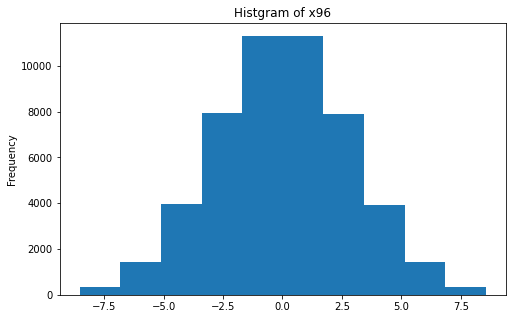

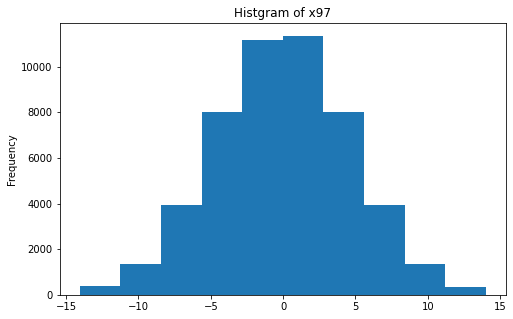

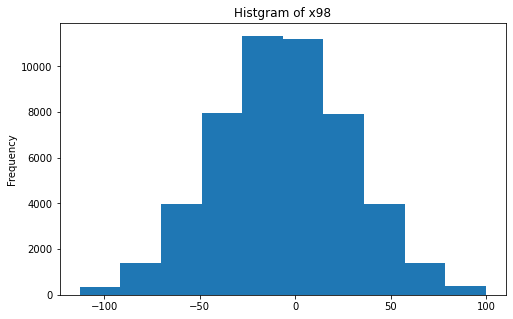

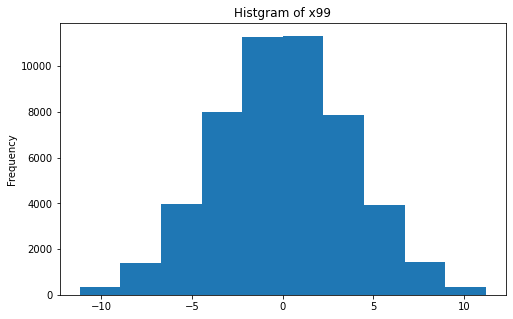

In [22]:
# generate histogram for all features
fig= plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
raw_y.plot(kind= 'hist',axes =ax1)
plt.title('Histgram for interest rate')
plt.show()

for i in cat_cols:
    fig= plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)
    raw[i].value_counts().plot(kind= 'bar',axes =ax1)
    plt.title('Histgram for feature: %s' %(i))
    ax2 = fig.add_subplot(1,2,2)
    raw[i].value_counts(normalize = 'True').plot(kind= 'bar', axes =ax2)
    plt.title('Histgram for feature: %s (in percentate)' %(i))
    plt.show()

for i in num_cols:
    a = raw[i]
    b = a[abs(a - a.mean()) <=3*a.std()]
    fig= plt.figure(figsize=(8,5))
    b.plot(kind= 'hist',bins = 10)
    plt.title('Histgram of %s' %(i))
    plt.show()

In [23]:
## Make a copy of raw input, will be used later as input variables in the linear regression model 
raw_bp_linear = copy.deepcopy(raw)

### Data preparation for tree model: 

In [24]:
### Replace the Null value with very large number (10**20), let tree model to interpret by itself
for i in num_cols:
    raw[i].fillna(10**20,inplace=True)

In [ ]:
### Label encoding for categorical feature
from sklearn import preprocessing
LBL = preprocessing.LabelEncoder()
dict_list = []
for i in cat_cols:
    raw[i] = LBL.fit_transform(raw[i].fillna('0'))
    j = dict(zip(np.arange(len(LBL.classes_)),LBL.classes_))
    k = {i:j}
    dict_list.append(k)
    
# uncomment the following print statement if you want to see the dictionary
#print(dict_list)

In [26]:
### Split into training and test dataset
from sklearn.model_selection import train_test_split
x = raw[:len_train]
y = raw_y[:len_train]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state=42)
holdout_x = raw[len_train:]
holdout_y = raw_y[len_train:]

In [27]:
### Build random forest model

from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [28]:
rfr = RandomForestRegressor(n_jobs=-1) 

#### hyper-parameter search: n_estimators
start to build random forest model"
To reduce the code running time, the process of hypermeter grid search for (n_estimator)
which may take one hour or so. Here we only use the final search result
If interested in checking the search process, run the following cell

In [ ]:
param_grid = { 
    'n_estimators': [60,120,180]

}

print('start the hypermeter grid search for n_estimator, it may take a few minutes')
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
CV_rfr.fit(train_x, train_y)

#best_estimators = CV_rfr.best_params_.values()[0]
best_estimators = CV_rfr.best_params_["n_estimators"]

print(' hypermeter grid search is over')
print('The best paramter for n_estimator is:', best_estimators)

In [29]:
### Develop a random forest model with 'n_estimators' = best_estimators

print('random forest model is developing, it may take 10 minutes')
best_estimators = 180
rfr_best = RandomForestRegressor(n_jobs=-1,n_estimators=best_estimators) 
rfr_best.fit(train_x, train_y)

random forest model is developing, it may take 10 minutes


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
### Save the model in local disk

from sklearn.externals import joblib
joblib.dump(rfr_best, 'rforest.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['rforest.pkl']

In [31]:
### Evaluate the training AUC performance of the model
from sklearn.metrics import roc_auc_score

rfr_load = joblib.load('rforest.pkl')
print('random forest model is running')
train_y_pred = rfr_load.predict(train_x)
auc_train = roc_auc_score(train_y, train_y_pred)
print('Training AUC: ', auc_train)

random forest model is running
Training AUC:  1.0


In [32]:
### Make prediction on test data
test_y_pred = rfr_load.predict(test_x)
auc_test = roc_auc_score(test_y, test_y_pred)
print('Testing AUC: ', auc_test)

Testing AUC:  0.9366814302563101
